<img src="http://hilpisch.com/tpq_logo.png" alt="The Python Quants" width="35%" align="right" border="0"><br>

# Python for Finance (2nd ed.)

**Mastering Data-Driven Finance**

&copy; Dr. Yves J. Hilpisch | The Python Quants GmbH

<img src="http://hilpisch.com/images/py4fi_2nd_shadow.png" width="300px" align="left">

# Trading Strategies (b)

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
from pylab import mpl, plt
import warnings

In [2]:
warnings.simplefilter('ignore')
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
np.random.seed(1000)
%matplotlib inline

## Linear OLS Regression

### The Data

In [3]:
raw = pd.read_csv('../../source/tr_eikon_eod_data.csv',
                  index_col=0, parse_dates=True).dropna()

In [4]:
raw.columns

Index(['AAPL.O', 'MSFT.O', 'INTC.O', 'AMZN.O', 'GS.N', 'SPY', '.SPX', '.VIX',
       'EUR=', 'XAU=', 'GDX', 'GLD'],
      dtype='object')

In [5]:
symbol = 'EUR='

In [6]:
data = pd.DataFrame(raw[symbol])

In [7]:
data['returns'] = np.log(data / data.shift(1))

In [8]:
data.dropna(inplace=True)

In [9]:
data['direction'] = np.sign(data['returns']).astype(int)

In [10]:
data.head()

,EUR=,returns,direction
Date,,,
2010-01-05,1.4368,-0.002988,-1
2010-01-06,1.4412,0.003058,1
2010-01-07,1.4318,-0.006544,-1
2010-01-08,1.4412,0.006544,1
2010-01-11,1.4513,0.006984,1


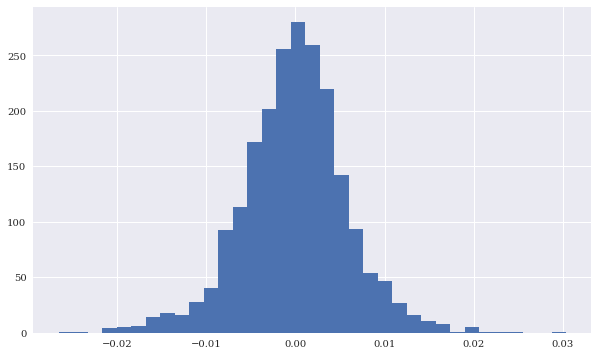

In [11]:
data['returns'].hist(bins=35, figsize=(10, 6));
# plt.savefig('../../images/ch15/strat_ml_01.png')

In [12]:
lags = 2

In [13]:
def create_lags(data):
    global cols
    cols = []
    for lag in range(1, lags + 1):
        col = 'lag_{}'.format(lag)
        data[col] = data['returns'].shift(lag)
        cols.append(col)

In [14]:
create_lags(data)

In [15]:
data.head()

,EUR=,returns,direction,lag_1,lag_2
Date,,,,,
2010-01-05,1.4368,-0.002988,-1,NaN,NaN
2010-01-06,1.4412,0.003058,1,-0.002988,NaN
2010-01-07,1.4318,-0.006544,-1,0.003058,-0.002988
2010-01-08,1.4412,0.006544,1,-0.006544,0.003058
2010-01-11,1.4513,0.006984,1,0.006544,-0.006544


In [16]:
data.dropna(inplace=True)

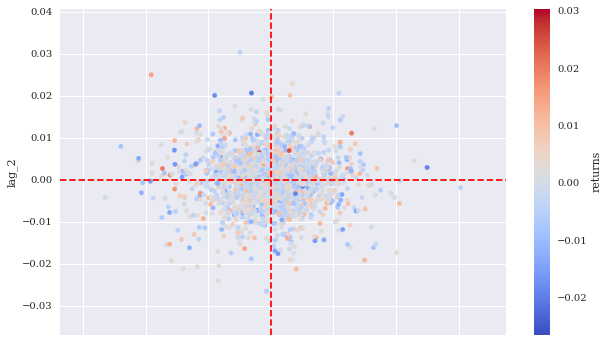

In [17]:
data.plot.scatter(x='lag_1', y='lag_2', c='returns', 
                  cmap='coolwarm', figsize=(10, 6), colorbar=True)
plt.axvline(0, c='r', ls='--')
plt.axhline(0, c='r', ls='--');
# plt.savefig('../../images/ch15/strat_ml_02.png');

### Regression

In [18]:
from sklearn.linear_model import LinearRegression  

In [19]:
model = LinearRegression()  

In [20]:
data['pos_ols_1'] = model.fit(data[cols], data['returns']).predict(data[cols])  

In [21]:
data['pos_ols_2'] = model.fit(data[cols], data['direction']).predict(data[cols])  

In [22]:
data[['pos_ols_1', 'pos_ols_2']].head()

,pos_ols_1,pos_ols_2
Date,,
2010-01-07,-0.000166,-0.000086
2010-01-08,0.000017,0.040404
2010-01-11,-0.000244,-0.011756
2010-01-12,-0.000139,-0.043398
2010-01-13,-0.000022,0.002237


In [23]:
data[['pos_ols_1', 'pos_ols_2']] = np.where(
            data[['pos_ols_1', 'pos_ols_2']] > 0, 1, -1)  

In [24]:
data['pos_ols_1'].value_counts()  

-1    1847
 1     288
Name: pos_ols_1, dtype: int64

In [25]:
data['pos_ols_2'].value_counts()  

 1    1377
-1     758
Name: pos_ols_2, dtype: int64

In [26]:
(data['pos_ols_1'].diff() != 0).sum()  

555

In [27]:
(data['pos_ols_2'].diff() != 0).sum()  

762

In [28]:
data['strat_ols_1'] = data['pos_ols_1'] * data['returns']

In [29]:
data['strat_ols_2'] = data['pos_ols_2'] * data['returns']

In [30]:
data[['returns', 'strat_ols_1', 'strat_ols_2']].sum().apply(np.exp)

returns        0.810644
strat_ols_1    0.942422
strat_ols_2    1.339286
dtype: float64

In [31]:
(data['direction'] == data['pos_ols_1']).value_counts()  

False    1093
True     1042
dtype: int64

In [32]:
(data['direction'] == data['pos_ols_2']).value_counts()  

True     1096
False    1039
dtype: int64

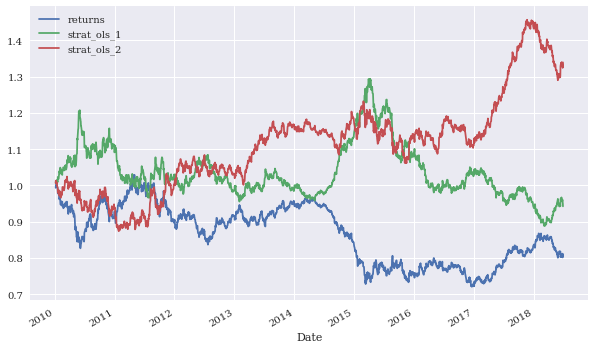

In [33]:
data[['returns', 'strat_ols_1', 'strat_ols_2']].cumsum(
        ).apply(np.exp).plot(figsize=(10, 6));
# plt.savefig('../../images/ch15/strat_ml_03.png');

## Clustering

In [34]:
from sklearn.cluster import KMeans

In [35]:
model = KMeans(n_clusters=2, random_state=0)  #  <1>

In [36]:
model.fit(data[cols])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

In [37]:
data['pos_clus'] = model.predict(data[cols])

In [38]:
data['pos_clus'] = np.where(data['pos_clus'] == 1, -1, 1)  

In [39]:
data['pos_clus'].values

array([-1,  1, -1, ...,  1,  1, -1])

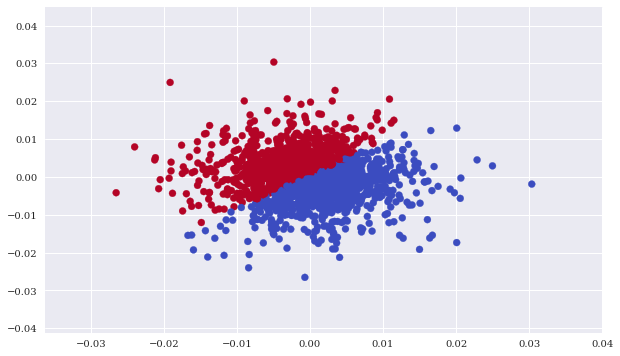

In [40]:
plt.figure(figsize=(10, 6))
plt.scatter(data[cols].iloc[:, 0], data[cols].iloc[:, 1],
            c=data['pos_clus'], cmap='coolwarm');
# plt.savefig('../../images/ch15/strat_ml_04.png');

In [41]:
data['strat_clus'] = data['pos_clus'] * data['returns']

In [42]:
data[['returns', 'strat_clus']].sum().apply(np.exp)

returns       0.810644
strat_clus    1.277133
dtype: float64

In [43]:
(data['direction'] == data['pos_clus']).value_counts()

True     1077
False    1058
dtype: int64

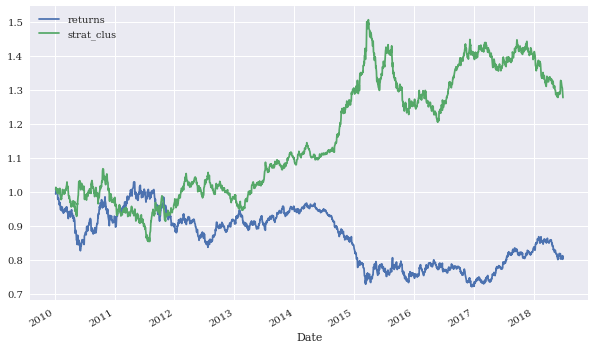

In [44]:
data[['returns', 'strat_clus']].cumsum().apply(np.exp).plot(figsize=(10, 6));
# plt.savefig('../../images/ch15/strat_ml_05.png');

## Frequency Approach

In [45]:
def create_bins(data, bins=[0]):
    global cols_bin
    cols_bin = []
    for col in cols:
        col_bin = col + '_bin'
        data[col_bin] = np.digitize(data[col], bins=bins)  
        cols_bin.append(col_bin)

In [46]:
create_bins(data)

In [47]:
data[cols_bin + ['direction']].head()  

,lag_1_bin,lag_2_bin,direction
Date,,,
2010-01-07,1,0,-1
2010-01-08,0,1,1
2010-01-11,1,0,1
2010-01-12,1,1,-1
2010-01-13,0,1,1


In [48]:
grouped = data.groupby(cols_bin + ['direction'])
grouped.size()  

lag_1_bin  lag_2_bin  direction
0          0          -1           239
                       0             4
                       1           258
           1          -1           262
                       1           288
1          0          -1           272
                       0             1
                       1           278
           1          -1           278
                       0             4
                       1           251
dtype: int64

In [49]:
res = grouped['direction'].size().unstack(fill_value=0)  

In [50]:
def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]  

In [51]:
res.style.apply(highlight_max, axis=1)  

In [52]:
data['pos_freq'] = np.where(data[cols_bin].sum(axis=1) == 2, -1, 1)  

In [53]:
(data['direction'] == data['pos_freq']).value_counts()

True     1102
False    1033
dtype: int64

In [54]:
data['strat_freq'] = data['pos_freq'] * data['returns']

In [55]:
data[['returns', 'strat_freq']].sum().apply(np.exp)

returns       0.810644
strat_freq    0.989513
dtype: float64

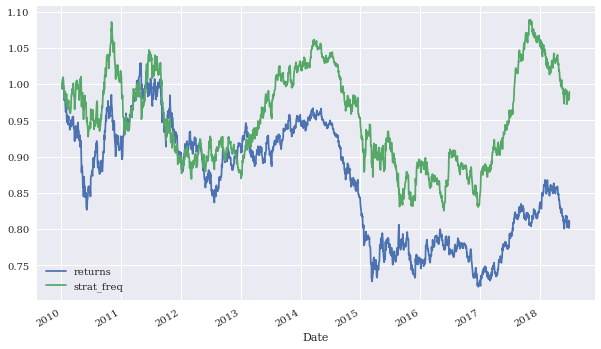

In [56]:
data[['returns', 'strat_freq']].cumsum().apply(np.exp).plot(figsize=(10, 6));
# plt.savefig('../../images/ch15/strat_ml_06.png');

## Classification Algorithms

In [57]:
from sklearn import linear_model
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

In [58]:
C = 1

In [59]:
models = {
    'log_reg': linear_model.LogisticRegression(C=C),
    'gauss_nb': GaussianNB(),
    'svm': SVC(C=C)
}

In [60]:
def fit_models(data):  
    mfit = {model: models[model].fit(data[cols_bin], data['direction'])
            for model in models.keys()} 

In [61]:
fit_models(data)

In [62]:
def derive_positions(data):  
    for model in models.keys():
        data['pos_' + model] = models[model].predict(data[cols_bin])

In [63]:
derive_positions(data)

In [64]:
def evaluate_strats(data):  
    global sel
    sel = []
    for model in models.keys():
        col = 'strat_' + model 
        data[col] = data['pos_' + model] * data['returns']
        sel.append(col)
    sel.insert(0, 'returns')

In [65]:
evaluate_strats(data)

In [66]:
sel.insert(1, 'strat_freq')

In [67]:
data[sel].sum().apply(np.exp)  

returns           0.810644
strat_freq        0.989513
strat_log_reg     1.243322
strat_gauss_nb    1.243322
strat_svm         0.989513
dtype: float64

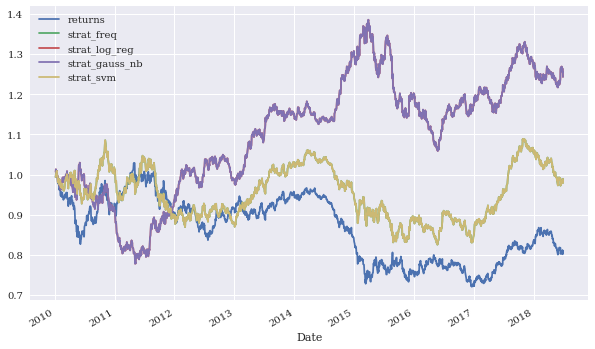

In [68]:
data[sel].cumsum().apply(np.exp).plot(figsize=(10, 6));
# plt.savefig('../../images/ch15/strat_ml_07.png')

In [69]:
data = pd.DataFrame(raw[symbol])

In [70]:
data['returns'] = np.log(data / data.shift(1))

In [71]:
data['direction'] = np.sign(data['returns'])

In [72]:
lags = 5  
create_lags(data)
data.dropna(inplace=True)

In [73]:
create_bins(data)  
cols_bin

['lag_1_bin', 'lag_2_bin', 'lag_3_bin', 'lag_4_bin', 'lag_5_bin']

In [74]:
data[cols_bin].head()

,lag_1_bin,lag_2_bin,lag_3_bin,lag_4_bin,lag_5_bin
Date,,,,,
2010-01-12,1,1,0,1,0
2010-01-13,0,1,1,0,1
2010-01-14,1,0,1,1,0
2010-01-15,0,1,0,1,1
2010-01-19,0,0,1,0,1


In [75]:
data.dropna(inplace=True)

In [76]:
fit_models(data)

In [77]:
derive_positions(data)

In [78]:
evaluate_strats(data)

In [79]:
data[sel].sum().apply(np.exp)

returns           0.805002
strat_log_reg     0.971623
strat_gauss_nb    0.986420
strat_svm         1.452406
dtype: float64

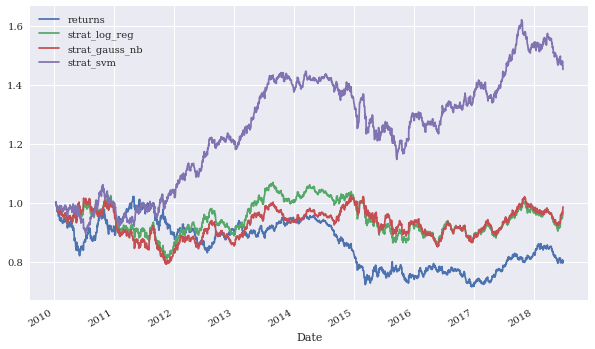

In [80]:
data[sel].cumsum().apply(np.exp).plot(figsize=(10, 6));
# plt.savefig('../../images/ch15/strat_ml_08.png');

In [81]:
mu = data['returns'].mean()  
v = data['returns'].std()  

In [82]:
bins = [mu - v, mu, mu + v]  
bins  

[-0.006033537040418665, -0.00010174015279231306, 0.005830056734834039]

In [83]:
create_bins(data, bins)

In [84]:
data[cols_bin].head()

,lag_1_bin,lag_2_bin,lag_3_bin,lag_4_bin,lag_5_bin
Date,,,,,
2010-01-12,3,3,0,2,1
2010-01-13,1,3,3,0,2
2010-01-14,2,1,3,3,0
2010-01-15,1,2,1,3,3
2010-01-19,0,1,2,1,3


In [85]:
fit_models(data)

In [86]:
derive_positions(data)

In [87]:
evaluate_strats(data)

In [88]:
data[sel].sum().apply(np.exp)

returns           0.805002
strat_log_reg     1.431120
strat_gauss_nb    1.815304
strat_svm         5.653433
dtype: float64

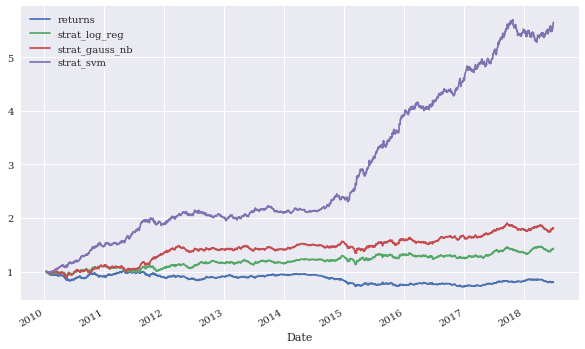

In [89]:
data[sel].cumsum().apply(np.exp).plot(figsize=(10, 6));
# plt.savefig('../../images/ch15/strat_ml_09.png')

### Sequential Train-Test Split

In [90]:
split = int(len(data) * 0.5)

In [91]:
train = data.iloc[:split].copy()  

In [92]:
fit_models(train)  

In [93]:
test = data.iloc[split:].copy()  

In [94]:
derive_positions(test)  

In [95]:
evaluate_strats(test)  

In [96]:
test[sel].sum().apply(np.exp)

returns           0.850291
strat_log_reg     0.962989
strat_gauss_nb    0.941172
strat_svm         1.048966
dtype: float64

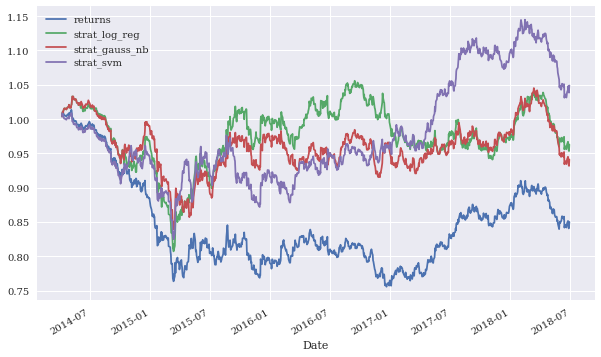

In [97]:
test[sel].cumsum().apply(np.exp).plot(figsize=(10, 6));
# plt.savefig('../../images/ch15/strat_ml_10.png');

### Randomized Train-Test Split

In [98]:
from sklearn.model_selection import train_test_split

In [99]:
train, test = train_test_split(data, test_size=0.5,
                               shuffle=True, random_state=100)

In [100]:
train = train.copy().sort_index()  

In [101]:
train[cols_bin].head()

,lag_1_bin,lag_2_bin,lag_3_bin,lag_4_bin,lag_5_bin
Date,,,,,
2010-01-12,3,3,0,2,1
2010-01-13,1,3,3,0,2
2010-01-14,2,1,3,3,0
2010-01-15,1,2,1,3,3
2010-01-20,1,0,1,2,1


In [102]:
test = test.copy().sort_index()  

In [103]:
fit_models(train)

In [104]:
derive_positions(test)

In [105]:
evaluate_strats(test)

In [106]:
test[sel].sum().apply(np.exp)

returns           0.878078
strat_log_reg     0.735893
strat_gauss_nb    0.765009
strat_svm         0.695428
dtype: float64

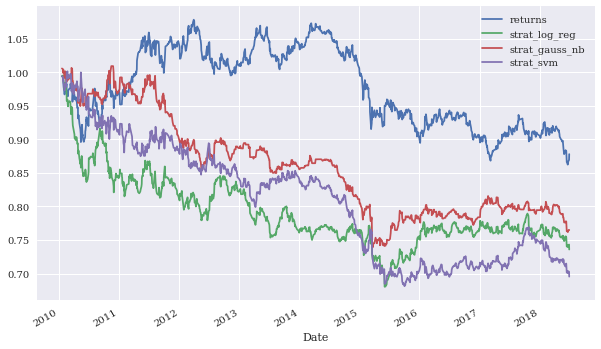

In [107]:
test[sel].cumsum().apply(np.exp).plot(figsize=(10, 6));
# plt.savefig('../../images/ch15/strat_ml_11.png');

## Deep Neural Network

### DNN with scikit-learn

In [108]:
from sklearn.neural_network import MLPClassifier

In [109]:
model = MLPClassifier(solver='lbfgs', alpha=1e-5,
                     hidden_layer_sizes=2 * [250], random_state=1)

In [110]:
%time model.fit(data[cols_bin], data['direction'])

CPU times: user 21 s, sys: 125 ms, total: 21.1 s
Wall time: 5.35 s


MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=[250, 250], learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=1, shuffle=True, solver='lbfgs', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [111]:
data['pos_dnn_sk'] = model.predict(data[cols_bin])

In [112]:
data['strat_dnn_sk'] = data['pos_dnn_sk'] * data['returns']

In [113]:
data[['returns', 'strat_dnn_sk']].sum().apply(np.exp)

returns          0.805002
strat_dnn_sk    34.140326
dtype: float64

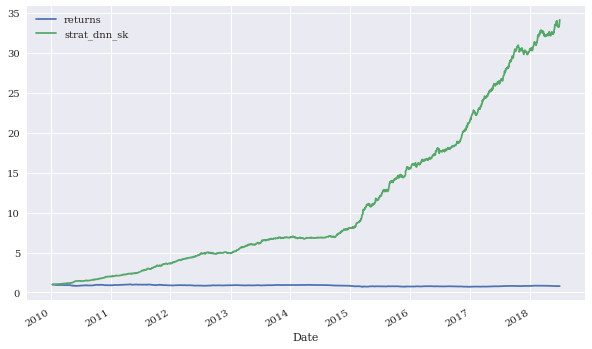

In [114]:
data[['returns', 'strat_dnn_sk']].cumsum().apply(np.exp).plot(figsize=(10, 6));
# plt.savefig('../../images/ch15/strat_ml_12.png');

In [115]:
train, test = train_test_split(data, test_size=0.5, random_state=100)

In [116]:
train = train.copy().sort_index()

In [117]:
test = test.copy().sort_index()

In [118]:
model = MLPClassifier(solver='lbfgs', alpha=1e-5, max_iter=500,
                     hidden_layer_sizes=3 * [500], random_state=1)  

In [119]:
%time model.fit(train[cols_bin], train['direction'])

CPU times: user 3min 47s, sys: 889 ms, total: 3min 48s
Wall time: 57.6 s


MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=[500, 500, 500], learning_rate='constant',
       learning_rate_init=0.001, max_iter=500, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=1, shuffle=True, solver='lbfgs', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [120]:
test['pos_dnn_sk'] = model.predict(test[cols_bin])

In [121]:
test['strat_dnn_sk'] = test['pos_dnn_sk'] * test['returns']

In [122]:
test[['returns', 'strat_dnn_sk']].sum().apply(np.exp)

returns         0.878078
strat_dnn_sk    1.115826
dtype: float64

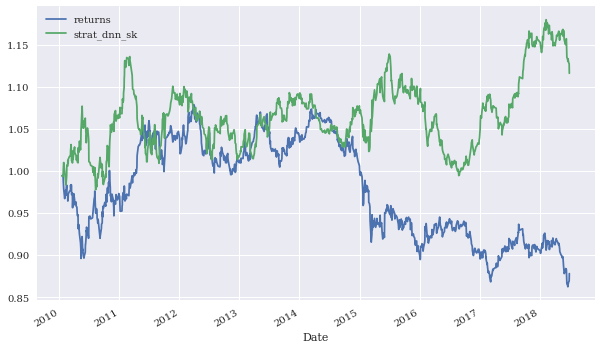

In [123]:
test[['returns', 'strat_dnn_sk']].cumsum().apply(np.exp).plot(figsize=(10, 6));
# plt.savefig('../../images/ch15/strat_ml_13.png');

### DNN with TensorFlow

In [124]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

In [125]:
fc = [tf.contrib.layers.real_valued_column('lags', dimension=lags)]

In [126]:
model = tf.contrib.learn.DNNClassifier(hidden_units=3 * [500],
                                       n_classes=len(bins) + 1,
                                       feature_columns=fc)

In [127]:
def input_fn():
    fc = {'lags': tf.constant(data[cols_bin].values)}
    la = tf.constant(data['direction'].apply(lambda x: 0 if x < 0 else 1).values,
                     shape=[data['direction'].size, 1])
    return fc, la

In [128]:
%time model.fit(input_fn=input_fn, steps=500)  

CPU times: user 2min 47s, sys: 3.63 s, total: 2min 50s
Wall time: 29 s


DNNClassifier(params={'head': <tensorflow.contrib.learn.python.learn.estimators.head._MultiClassHead object at 0x1a19b32cc0>, 'hidden_units': [500, 500, 500], 'feature_columns': (_RealValuedColumn(column_name='lags', dimension=5, default_value=None, dtype=tf.float32, normalizer=None),), 'optimizer': None, 'activation_fn': <function relu at 0x1a189da598>, 'dropout': None, 'gradient_clip_norm': None, 'embedding_lr_multipliers': None, 'input_layer_min_slice_size': None})

In [129]:
model.evaluate(input_fn=input_fn, steps=1)  

{'loss': 0.6852374, 'accuracy': 0.54971856, 'global_step': 500}

In [130]:
pred = np.array(list(model.predict(input_fn=input_fn)))  
pred[:10]  

array([0, 1, 0, 0, 0, 1, 0, 1, 1, 0])

In [131]:
data['pos_dnn_tf'] = np.where(pred > 0, 1, -1)  

In [132]:
data['strat_dnn_tf'] = data['pos_dnn_tf'] * data['returns']

In [133]:
data[['returns', 'strat_dnn_tf']].sum().apply(np.exp)

returns         0.805002
strat_dnn_tf    2.924040
dtype: float64

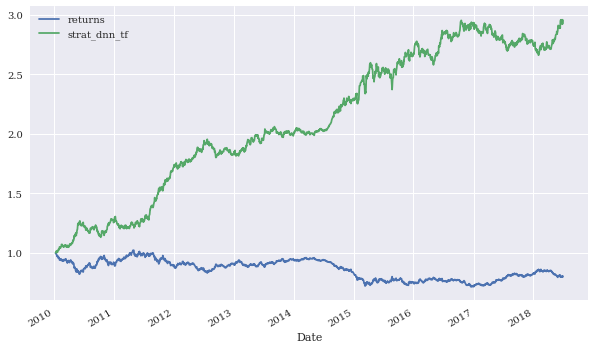

In [134]:
data[['returns', 'strat_dnn_tf']].cumsum(
        ).apply(np.exp).plot(figsize=(10, 6));
# plt.savefig('../../images/ch15/strat_ml_14.png');

In [135]:
model = tf.contrib.learn.DNNClassifier(hidden_units=3 * [500],
                                       n_classes=len(bins) + 1,
                                       feature_columns=fc)

In [136]:
data = train

In [137]:
%time model.fit(input_fn=input_fn, steps=2500)

CPU times: user 7min 10s, sys: 13.4 s, total: 7min 23s
Wall time: 1min 18s


DNNClassifier(params={'head': <tensorflow.contrib.learn.python.learn.estimators.head._MultiClassHead object at 0x1a188656d8>, 'hidden_units': [500, 500, 500], 'feature_columns': (_RealValuedColumn(column_name='lags', dimension=5, default_value=None, dtype=tf.float32, normalizer=None),), 'optimizer': None, 'activation_fn': <function relu at 0x1a189da598>, 'dropout': None, 'gradient_clip_norm': None, 'embedding_lr_multipliers': None, 'input_layer_min_slice_size': None})

In [138]:
data = test

In [139]:
model.evaluate(input_fn=input_fn, steps=1)

{'loss': 0.8435978, 'accuracy': 0.48311445, 'global_step': 2500}

In [140]:
pred = np.array(list(model.predict(input_fn=input_fn)))

In [141]:
test['pos_dnn_tf'] = np.where(pred > 0, 1, -1)

In [142]:
test['strat_dnn_tf'] = test['pos_dnn_tf'] * test['returns']

In [143]:
test[['returns', 'strat_dnn_sk', 'strat_dnn_tf']].sum().apply(np.exp)

returns         0.878078
strat_dnn_sk    1.115826
strat_dnn_tf    1.071912
dtype: float64

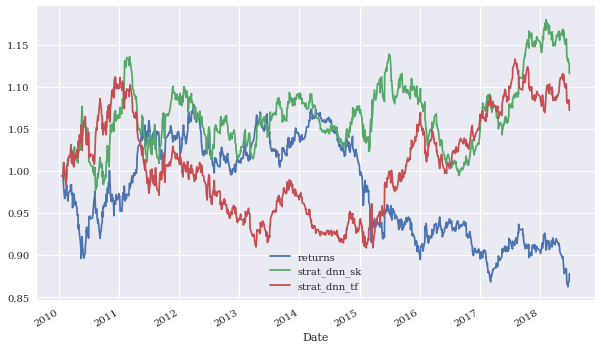

In [144]:
test[['returns', 'strat_dnn_sk', 'strat_dnn_tf']].cumsum(
        ).apply(np.exp).plot(figsize=(10, 6));
# plt.savefig('../../images/ch15/strat_ml_15.png');

<img src="http://hilpisch.com/tpq_logo.png" alt="The Python Quants" width="35%" align="right" border="0"><br>

<a href="http://tpq.io" target="_blank">http://tpq.io</a> | <a href="http://twitter.com/dyjh" target="_blank">@dyjh</a> | <a href="mailto:training@tpq.io">training@tpq.io</a>